In [1]:
from exp.expdata import GenExAdapter
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

from exp.evaluate.jsindy import evaluate_jmodel

ERROR:2025-08-22 13:25:11,539:jax._src.xla_bridge:502: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/jmsh/github/jsindy/env/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 500, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/jmsh/github/jsindy/env/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/jmsh/github/jsindy/env/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE
/home/jmsh/github/jsindy/env/lib/python3.12/site-packages/sympy2jax/sympy_module.py:291: UserWarning: `equinox.static_field` is 

In [2]:
noise = 0.1
dt_train = 2.0
t1=100.

expdata = GenExAdapter(system="vdp", t0=0., t1=t1, noise=noise, n_train=50, n_colloc=500, seed=1234)

In [3]:
x_true = expdata.x_true
t_true = expdata.t_true

t_train = expdata.t_train
x_train = expdata.x_train
t_train.shape

(50,)

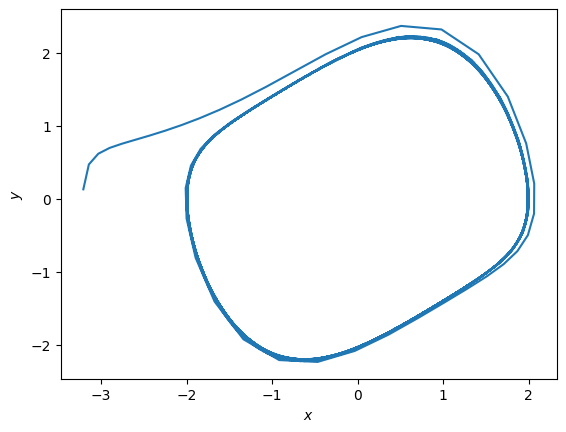

In [4]:
plt.plot(x_true[:,0], x_true[:,1])
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

# Learn Model

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
jax.config.update('jax_enable_x64',True)

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant, CholRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings, AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ
from jsindy.kernels import ConstantKernel, ScalarMaternKernel


## Let jsindy handle 2nd order

In [23]:
kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=2.0)
)   

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=2)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight = 20.
colloc_weight = 1e5
sparsifier = pySindySparsifier(STLSQ(threshold = 0.25,alpha = 0.1))
optimizer = AnnealedAlternatingActiveSetLMSolver(
    beta_reg=1e-5,
    solver_settings=optsettings,
    fixed_colloc_weight=colloc_weight,
    fixed_data_weight=data_weight,
    sparsifier = sparsifier,
    num_annealing_steps=3,
)

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    input_orders=(0, 1),
    ode_order=2,
    feature_names=['x']
)

In [118]:
from importlib import reload
import jsindy.optim.optimizers
reload(jsindy.optim.optimizers)
from jsindy.optim.optimizers import AnnealedAlternatingActiveSetLMSolver

In [ ]:
model.fit(expdata.t_train, expdata.x_train[:, :1], expdata.t_colloc)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.03316376e-08, dtype=float64), 'data_weight': 20.0, 'colloc_weight': 100000.0}
Solving for data_weight = 20.0, colloc_weight = 4000.0 beta_reg = 4e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 8.958, gradnorm = 293.8, alpha = 4.167, improvement_ratio = 1.014
Iteration 1, loss = 6.696, gradnorm = 88.83, alpha = 4.167, improvement_ratio = 0.7109
Iteration 2, loss = 5.628, gradnorm = 90.62, alpha = 3.472, improvement_ratio = 1.006
Iteration 3, loss = 5.406, gradnorm = 8.725, alpha = 2.894, improvement_ratio = 0.9494
Iteration 4, loss = 5.278, gradnorm = 5.261, alpha = 2.411, improvement_ratio = 0.9568
Iteration 5, loss = 5.197, gradnorm = 3.612, alpha = 2.009, improvement_ratio = 0.96
Line Search Failed!
Final Iteration Results
Iteration 79, loss = 5.005, gradnorm = 0.0003444, alpha = 21.74, improvement_ratio = -8.263
Solving for data_weight = 20.0, colloc_weight = 20000.0 beta_reg = 2e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 5.573, gradnorm = 140.6, alpha = 4.167, improvement_ratio = 1.001
Iteration 1, loss = 5.564, gradnorm = 9.813, alpha = 3.472, improvement_ratio = 0.9952
Iteration 2, loss = 5.561, gradnorm = 0.6225, alpha = 2.894, improvement_ratio = 0.9976
Iteration 3, loss = 5.559, gradnorm = 0.3137, alpha = 2.411, improvement_ratio = 0.9997
Iteration 4, loss = 5.557, gradnorm = 0.1663, alpha = 2.009, improvement_ratio = 1.001
Iteration 5, loss = 5.556, gradnorm = 0.1083, alpha = 1.674, improvement_ratio = 1.001
Line Search Failed!
Final Iteration Results
Iteration 78, loss = 5.506, gradnorm = 3.775e-06, alpha = 19.66, improvement_ratio = -4.866e+05
Solving for data_weight = 20.0, colloc_weight = 100000.0 beta_reg = 1e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 5.629, gradnorm = 156.9, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 5.629, gradnorm = 2.952, alpha = 3.472, improvement_ratio = 0.9992
Iteration 2, loss = 5.628, gradnorm = 0.08255, alpha = 2.894, improvement_ratio = 0.9996
Iteration 3, loss = 5.628, gradnorm = 0.04825, alpha = 2.411, improvement_ratio = 0.9998
Iteration 4, loss = 5.628, gradnorm = 0.02955, alpha = 2.009, improvement_ratio = 0.9998
Iteration 5, loss = 5.628, gradnorm = 0.01841, alpha = 1.674, improvement_ratio = 0.9998
Line Search Failed!
Final Iteration Results
Iteration 98, loss = 5.62, gradnorm = 5.01e-06, alpha = 3.99e+05, improvement_ratio = -1.333e+06
Model after smooth warm start
(x)'' = 3.332 1 + -1.075 x + -0.103 (x') + -0.784 x^2 + 0.085 x (x') + -0.878 (x')^2
Alternating Activeset Sparsifier


In [ ]:
x_pred = model.predict_state(expdata.t_true)
x_true = expdata.x_true
model.print()

(x)'' = 3.332 1 + -1.075 x + -0.103 (x') + -0.784 x^2 + 0.085 x (x') + -0.878 (x')^2


In [15]:
expdata.print()

x' = 1 x'
x'' = -1 x + 0.5 x' + -0.5 x^2 x'


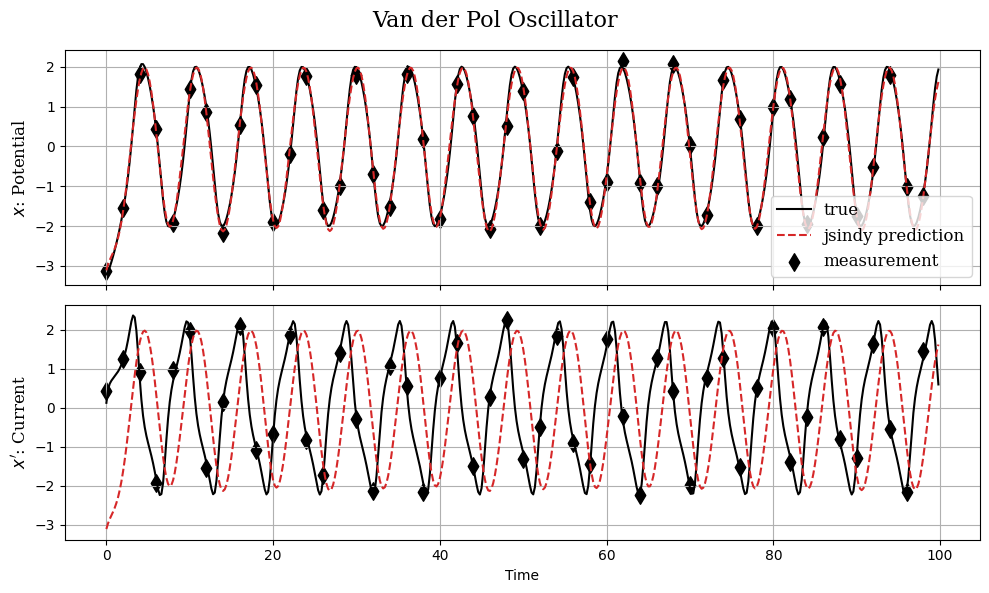

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6), sharex=True)

fontname = 'serif'

ax1.plot(t_true, x_true[:,0], label="true", c='black',)
ax1.plot(t_true, x_pred[:,0], label='jsindy prediction',linestyle='--',c='tab:red')
ax1.scatter(t_train, x_train[:,0], label="measurement", marker='d',s=80,c='black')
ax1.set_ylabel(r"$x$: Potential", fontname=fontname,size=12)
ax1.legend(prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], label='predator', c='black')
ax2.plot(t_true, x_pred[:,1], label='prediction', linestyle='--', c='tab:red')
ax2.scatter(t_train, x_train[:,1], label="measurement", c='black', marker='d',s=80)
ax2.set_ylabel(r"$x'$: Current", fontname=fontname,size=12)
ax2.set_xlabel("Time")
ax2.grid(True)
# ax2.legend(prop={'family': fontname, 'size':12})

plt.suptitle("Van der Pol Oscillator", fontsize=16, fontname=fontname)
plt.tight_layout()
plt.show()